In [ ]:

"""
Author: Zhenggang Li & A.V. Ronquillo
Date: May 21, 2024

## Note: Note: The author generated this text in part with GPT-4,
OpenAI’s large-scale language-generation model. Upon generating
draft code, the author reviewed, edited, and revised the code
to their own liking and takes ultimate responsibility for
the content of this code.

"""

# Introduction

This notebook introduces methods for evaluating the performance of a machine learning model in identifying and locating different animal species in trail camera photos. A classification model is used to classify and locate animal species across datasets of varying sizes (100, 500, and 1000 images). The notebook employs Python-based libraries such as `fastai`, `matplotlib`, and `sklearn` to preprocess data, train a convolutional neural network (CNN) using the `resnet34` architecture, and generate classification reports. These reports include precision, recall, F1-score, and support metrics for each class, visualized through bar plots.

# Critical Uses & Adaptability

## What the Notebook Can Be Used For:

- **Dataset Exploration:**  
  This notebook allows users to explore datasets of varying sizes, providing insights into how dataset size impacts model performance. It evaluates classification accuracy and localization metrics, offering a detailed understanding of the dataset's characteristics.

- **Educational Purposes & Demonstrations:**  
  The notebook serves as an educational resource for understanding Python-based machine learning workflows. It demonstrates the use of libraries like `fastai` and `sklearn` for image classification tasks, making it suitable for teaching concepts such as CNNs, data preprocessing, and performance evaluation.

- **Feature Extraction:**  
  By fine-tuning the `resnet34` model, the notebook extracts meaningful features from images, which can be used for further analysis or integrated into other machine learning pipelines.

## How the Notebook Can Be Adapted:

- **Integration with Spatial Design & Architectural Studies:**  
  The notebook can be adapted for site analysis by replacing the animal image dataset with datasets containing architectural elements or spatial layouts. This enables the classification of design features or spatial patterns.

- **Variables & Customization:**  
  - The `species` and `dataset_size` variables in the dataset processing cells can be modified to accommodate different classes or dataset sizes.  
  - The `batch_tfms` and `item_tfms` parameters in the `ImageDataLoaders` initialization allow customization of image transformations.

- **Swapping Datasets:**  
  - The dataset path in the `base_path` variable (e.g., in the cell processing the 100 dataset) can be updated to point to a custom dataset. This enables the notebook to work with entirely different image collections.

- **Scalability:**  
  The notebook can be scaled to handle larger datasets by adjusting the `batch_size` and `num_workers` parameters in the data loader. Additionally, the number of epochs in the `fine_tune` method can be increased for more extensive training.

# Module: Importing Additional Necessary Python Packages


For the purposes of the notebook in CoLab and the consideration of the runtime, the classification report will only be visualized through the 100, 500, and 1000 dataset for further analysis of the model's animal classification accuracy.

The `matplotlib.pyplot` is assigned the alias of `plt`. This imported module is a library used for creating two-dimensional plots in Python. `sklearn.metrics` is used for visualization and model evaluation metrics. It essentially imports the `classification_report` function from the module. This element is another method of visualizing classification and localization accuracy in various quantitative metrics, allowing detailed model performance analysis. In doing so, it can provide insights that a confusion matrix may not necessarily offer. A classification report evaluates the performance of a classification model by calculating precision, recall, F1-score, and support for each class.

In [1]:
import os
import requests
import zipfile
from pathlib import Path

# FastAI and PyTorch imports
from fastai.vision.all import *

# Visualization and analysis libraries
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## Borealis Data Repository Configuration

This code block establishes access to the Borealis Data Repository using the requests library for HTTP communications. The `get_public_dataset_info()` function takes a DOI as input and makes an API call to retrieve dataset metadata. It constructs the API endpoint URL, sends a request with the persistent ID parameter, and handles the response with error checking. The example usage demonstrates accessing the "Understanding Animals jupyter notebook data" collection using DOI `"doi:10.5683/SP3/H3HGWF"`, which contains animal images organized by dataset size.

The data is hosted in the University of Manitoba Dataverse (https://borealisdata.ca/dataverse/manitoba), a research data repository. The images used in this notebook were collected as part of the 'Understanding Animals' project at University of Manitoba Faculty of Architecture, online at [Wild Winnipeg](https://www.wildwinnipeg.org/) and [Teaching with Images](https://pressbooks.openedmb.ca/teachingwithimages/).

In [ ]:
# Borealis API configuration
BOREALIS_SERVER = "https://borealisdata.ca"

def get_public_dataset_info(persistent_id):
    """
    Get information about a public dataset from Borealis
    """
    url = f"{BOREALIS_SERVER}/api/datasets/:persistentId/"
    params = {"persistentId": persistent_id}

    response = requests.get(url, params=params)

    if response.status_code == 200:
        dataset_info = response.json()
    else:
        print(f"Cannot access dataset: {response.status_code}")
        return None

    # Get a list of files in a public dataset
    files_list = dataset_info['data']['latestVersion']['files']
    file_info_list = []

    # Iterate through the files list and append file ID and filename to the list
    for file_info in files_list:
        file_id = file_info['dataFile']['id']
        filename = file_info['dataFile']['filename']
        file_info_list.append({"file_id": file_id, "filename": filename})

    return file_info_list

def download_public_file(file_id, save_path="./"):
    """
    Download a specific public file from a dataset by its file ID
    No authentication required
    """
    url = f"{BOREALIS_SERVER}/api/access/datafile/{file_id}"

    response = requests.get(url, stream=True)

    if response.status_code == 200:
        # Determine filename from headers or URL
        filename = None
        if "Content-Disposition" in response.headers:
            cd = response.headers["Content-Disposition"]
            # Try to extract filename from content disposition
            if "filename=" in cd:
                filename = cd.split("filename=")[1].strip('"')

        # Fallback to extracting from URL if header not available or malformed
        if not filename:
             filename = url.split("/")[-1]

        file_path = os.path.join(save_path, filename)

        with open(file_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"✅ File downloaded to {file_path}")
        return file_path
    else:
        print(f"❌ Error {response.status_code}: File may be restricted or not found")
        return None

def is_zip_file(filepath):
    """
    Checks if a file is a valid zip file.
    """
    return zipfile.is_zipfile(filepath)

def unzip_file(filepath, extract_path="./"):
    """
    Unzips a zip file to a specified path and returns the name of the top-level extracted folder.
    Returns None if not a zip file or extraction fails.
    """
    if is_zip_file(filepath):
        try:
            with zipfile.ZipFile(filepath, 'r') as zip_ref:
                # Get the name of the top-level directory within the zip
                top_level_folder = None
                for file_info in zip_ref.infolist():
                    parts = file_info.filename.split('/')
                    if parts[0] and len(parts) > 1:
                        top_level_folder = parts[0]
                        break # Assuming the first entry gives the top-level folder

                zip_ref.extractall(extract_path)
                print(f"✅ Successfully unzipped {filepath} to {extract_path}")
                return top_level_folder

        except Exception as e:
            print(f"❌ Error unzipping {filepath}: {e}")
            return None
    else:
        print(f"ℹ️ {filepath} is not a valid zip file.")
        return None

print("🔧 Borealis API functions configured successfully")

🔧 Borealis API functions configured successfully


## Download & Extract the Dataset

This function downloads the dataset from Borealis using the file ID for "dataset-sizes.zip". The dataset contains animal images organized into different size categories (100, 500, 1000 images) for comparing model performance across varying dataset sizes.

In [ ]:
# Initialize Borealis dataset access
public_doi = "doi:10.5683/SP3/H3HGWF"  # DOI for 'Understanding Animals jupyter notebook data'
print("🔍 Retrieving dataset information from Borealis...")

# Get dataset file information
dataset_info = get_public_dataset_info(public_doi)
if dataset_info:
    print(f"📋 Found {len(dataset_info)} files in dataset")
    for file_info in dataset_info[:3]:  # Show first 3 files
        print(f"   • {file_info['filename']} (ID: {file_info['file_id']})")
else:
    print("❌ Failed to retrieve dataset information")

# Download the dataset-sizes.zip file
file_id = 965306  # file id for dataset-sizes.zip
print(f"\n📥 Downloading dataset (File ID: {file_id})...")
downloaded_file = download_public_file(file_id, "./")

# Extract the dataset
if downloaded_file:
    print("\n📦 Extracting dataset...")
    base_path = "./" + str(file_id)

    if is_zip_file(base_path):
        extracted_folder_name = unzip_file(base_path, "./")
        if extracted_folder_name:
            print(f"📁 Extracted folder name: {extracted_folder_name}")
            base_path = extracted_folder_name
        else:
            print("❌ Failed to extract dataset")
            base_path = None
    else:
        print(f"❌ The file {base_path} is not a valid zip file.")
        base_path = None
else:
    print("❌ Failed to download dataset")
    base_path = None

if base_path:
    print(f"\n✅ Dataset ready at: {base_path}")
    # Show directory structure
    if os.path.exists(base_path):
        print("📂 Directory structure:")
        for item in sorted(os.listdir(base_path)):
            if os.path.isdir(os.path.join(base_path, item)):
                print(f"   📁 {item}")
else:
    print("❌ Dataset setup failed. Please check the download and extraction process.")

🔍 Retrieving dataset information from Borealis...
📋 Found 7 files in dataset
   • 100grid-sample-images.zip (ID: 965307)
   • 4370-entire-subset.zip (ID: 965304)
   • cat-100.zip (ID: 965303)

📥 Downloading dataset (File ID: 965306)...
✅ File downloaded to ./965306

📦 Extracting dataset...
✅ Successfully unzipped ./965306 to ./
📁 Extracted folder name: dataset-sizes

✅ Dataset ready at: dataset-sizes
📂 Directory structure:
   📁 deer_100
   📁 deer_1000
   📁 deer_500
   📁 fox_100
   📁 fox_1000
   📁 fox_500
   📁 squirrel_100
   📁 squirrel_1000
   📁 squirrel_500


# Module: Error Handling Functions

This code block safely gets image files from a given path, ensuring robust image processing by handling corrupted or unidentifiable images. It allows the entire script to be more robust by preparing the image processing to deal with potential file issues.

In [ ]:
def safe_get_image_files(path):
    """
    Safely get image files from a path, skipping corrupted files
    """
    image_files = []

    if not os.path.exists(path):
        print(f"⚠️ Path does not exist: {path}")
        return image_files

    try:
        for img_path in get_image_files(path):
            try:
                # Attempt to open the image to verify it is not corrupted
                with PILImage.create(img_path) as img:
                    image_files.append(img_path)
            except Exception as e:
                print(f"⚠️ Skipping file {img_path} due to error: {e}")
    except Exception as e:
        print(f"❌ Error accessing path {path}: {e}")

    return image_files

print("🛡️ Error handling functions configured")

🛡️ Error handling functions configured


# Module: Dataset Processing & Model Training Pipeline

This comprehensive module handles the complete pipeline from data loading through model training to classification report generation. The function processes datasets for different sizes, trains a ResNet34 model using FastAI, and generates detailed classification reports with visualizations.

In [ ]:
def process_dataset_with_classification_report(base_path, species, size):
    """
    Process a dataset and generate a comprehensive classification report
    """
    print(f"\n{'='*60}")
    print(f"🔄 Processing {size} Dataset")
    print(f"{'='*60}")

    files = []

    # Gather files for all species for the given size
    print(f"📁 Collecting images for species: {species}")
    for animal in species:
        animal_path = Path(base_path) / f'{animal}_{size}'
        print(f"   🔍 Looking for {animal} images in: {animal_path}")

        animal_files = safe_get_image_files(animal_path)
        if animal_files:
            print(f"   ✅ Found {len(animal_files)} {animal} images")
            files.extend(animal_files)
        else:
            print(f"   ⚠️ No {animal} images found in {animal_path}")

    if not files:
        print(f"❌ No images found for dataset size {size}. Skipping...")
        print(f"   Expected path pattern: {base_path}/{{animal}}_{size}")
        return None

    print(f"\n📊 Total images collected: {len(files)}")

    # Verify we have images for each species
    species_counts = {}
    for file_path in files:
        species_name = file_path.parent.name.split('_')[0]
        species_counts[species_name] = species_counts.get(species_name, 0) + 1

    print("📈 Images per species:")
    for species_name, count in species_counts.items():
        print(f"   • {species_name}: {count} images")

    try:
        # Initialize Data Loaders
        print("\n🔧 Initializing data loaders...")
        dls = ImageDataLoaders.from_path_func(
            path=Path(base_path),
            fnames=files,
            label_func=lambda x: x.parent.name.split('_')[0],
            item_tfms=Resize(460),
            batch_tfms=aug_transforms(size=224),
            bs=32,
            num_workers=0,
            valid_pct=0.2  # 20% for validation
        )
        print("✅ Data loaders initialized successfully")

        # Show a sample batch
        print("\n🖼️ Sample batch:")
        dls.show_batch()

        # Initialize CNN Learner and Fine-Tune the Model
        print("\n🧠 Initializing CNN learner with ResNet34...")
        learn = cnn_learner(dls, resnet34, metrics=accuracy)

        print("🏋️ Fine-tuning model for 4 epochs...")
        learn.fine_tune(4)

        print("\n📋 Model results:")
        learn.show_results()

        # Generate predictions and classification report
        print("\n📊 Generating classification report...")

        # Get predictions and true labels
        preds, y_true = learn.get_preds()
        preds_softmax = preds.softmax(dim=1)
        y_pred = preds_softmax.argmax(dim=1)

        # Convert to numpy for sklearn
        y_true_np = y_true.cpu().numpy()
        y_pred_np = y_pred.cpu().numpy()

        # Get class names
        class_names = dls.vocab

        # Generate classification report
        report = classification_report(
            y_true_np,
            y_pred_np,
            target_names=class_names,
            output_dict=True
        )

        # Convert to DataFrame for visualization
        df = pd.DataFrame(report).transpose()

        # Print detailed classification report
        print("\n📈 Detailed Classification Report:")
        print("-" * 50)
        report_text = classification_report(
            y_true_np,
            y_pred_np,
            target_names=class_names
        )
        print(report_text)

        # Create visualization
        create_classification_report_visualization(df, size, class_names)

        print(f"\n✅ Successfully processed {size} dataset")
        print("-" * 60)

        return learn, df, report

    except Exception as e:
        print(f"❌ Error processing dataset: {e}")
        import traceback
        traceback.print_exc()
        return None

def create_classification_report_visualization(df, size, class_names):
    """
    Create a comprehensive visualization of the classification report
    """
    # Filter out summary rows for the main visualization
    class_df = df[df.index.isin(class_names)]

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Classification Report Analysis - {size} Dataset', fontsize=16, fontweight='bold')

    # 1. Bar plot for precision, recall, f1-score
    ax1 = axes[0, 0]
    x_pos = range(len(class_names))
    width = 0.25

    ax1.bar([p - width for p in x_pos], class_df['precision'], width,
            label='Precision', color='skyblue', alpha=0.8)
    ax1.bar(x_pos, class_df['recall'], width,
            label='Recall', color='lightcoral', alpha=0.8)
    ax1.bar([p + width for p in x_pos], class_df['f1-score'], width,
            label='F1-Score', color='lightgreen', alpha=0.8)

    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Scores')
    ax1.set_title('Precision, Recall, and F1-Score by Class')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(class_names, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Support (number of samples) bar chart
    ax2 = axes[0, 1]
    ax2.bar(class_names, class_df['support'], color='orange', alpha=0.7)
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Number of Samples')
    ax2.set_title('Support (Sample Count) by Class')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    # 3. Heatmap of metrics
    ax3 = axes[1, 0]
    metrics_for_heatmap = class_df[['precision', 'recall', 'f1-score']]
    sns.heatmap(metrics_for_heatmap.T, annot=True, fmt='.3f', cmap='RdYlBu_r',
                ax=ax3, cbar_kws={'label': 'Score'})
    ax3.set_title('Metrics Heatmap')
    ax3.set_xlabel('Classes')
    ax3.set_ylabel('Metrics')

    # 4. Summary statistics
    ax4 = axes[1, 1]

    # Get overall metrics
    accuracy = df.loc['accuracy', 'precision'] if 'accuracy' in df.index else 0
    macro_avg = df.loc['macro avg'] if 'macro avg' in df.index else None
    weighted_avg = df.loc['weighted avg'] if 'weighted avg' in df.index else None

    summary_text = f"Dataset Size: {size}\n\n"
    summary_text += f"Overall Accuracy: {accuracy:.3f}\n\n"

    if macro_avg is not None:
        summary_text += "Macro Average:\n"
        summary_text += f"  Precision: {macro_avg['precision']:.3f}\n"
        summary_text += f"  Recall: {macro_avg['recall']:.3f}\n"
        summary_text += f"  F1-Score: {macro_avg['f1-score']:.3f}\n\n"

    if weighted_avg is not None:
        summary_text += "Weighted Average:\n"
        summary_text += f"  Precision: {weighted_avg['precision']:.3f}\n"
        summary_text += f"  Recall: {weighted_avg['recall']:.3f}\n"
        summary_text += f"  F1-Score: {weighted_avg['f1-score']:.3f}\n"

    ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes, fontsize=12,
             verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3",
             facecolor="lightblue", alpha=0.5))
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    ax4.set_title('Summary Statistics')

    plt.tight_layout()
    plt.show()

    # Additional detailed metrics table
    print("\n📋 Detailed Metrics Table:")
    print(class_df.round(3).to_string())

print("🔧 Dataset processing and visualization functions configured")

🔧 Dataset processing and visualization functions configured


# Module: Dataset Processing Execution

This section executes the complete classification report pipeline for different dataset sizes. Each dataset is processed independently, allowing for comparison of model performance across varying amounts of training data.

## 100 Datset Classification Report

🚀 Starting 100 Dataset Analysis

🔄 Processing 100 Dataset
📁 Collecting images for species: ['fox', 'squirrel', 'deer']
   🔍 Looking for fox images in: dataset-sizes/fox_100
   ✅ Found 37 fox images
   🔍 Looking for squirrel images in: dataset-sizes/squirrel_100
   ✅ Found 107 squirrel images
   🔍 Looking for deer images in: dataset-sizes/deer_100
   ✅ Found 100 deer images

📊 Total images collected: 244
📈 Images per species:
   • fox: 37 images
   • squirrel: 107 images
   • deer: 100 images

🔧 Initializing data loaders...
✅ Data loaders initialized successfully

🖼️ Sample batch:

🧠 Initializing CNN learner with ResNet34...


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


🏋️ Fine-tuning model for 4 epochs...



📋 Model results:



📊 Generating classification report...



📈 Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

        deer       0.94      1.00      0.97        17
         fox       1.00      0.88      0.93         8
    squirrel       1.00      1.00      1.00        23

    accuracy                           0.98        48
   macro avg       0.98      0.96      0.97        48
weighted avg       0.98      0.98      0.98        48



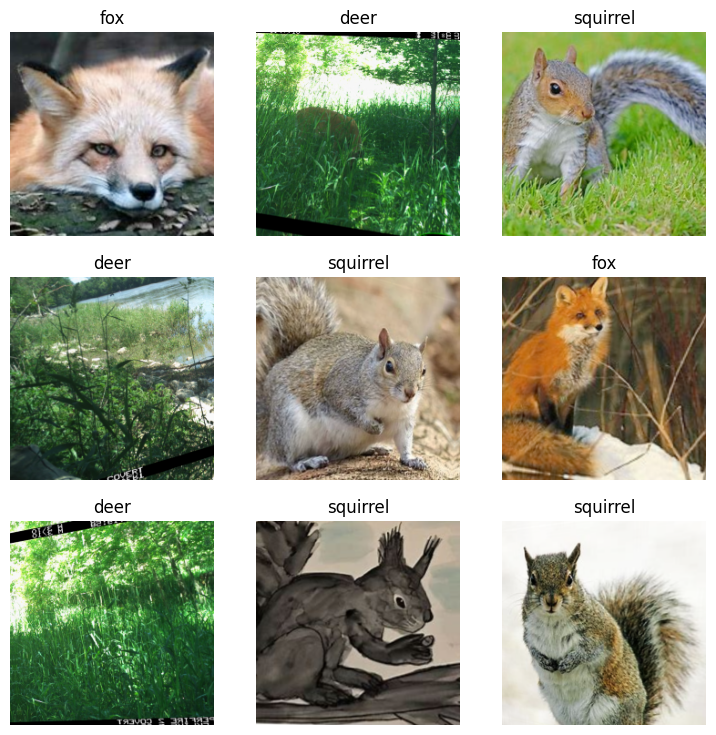

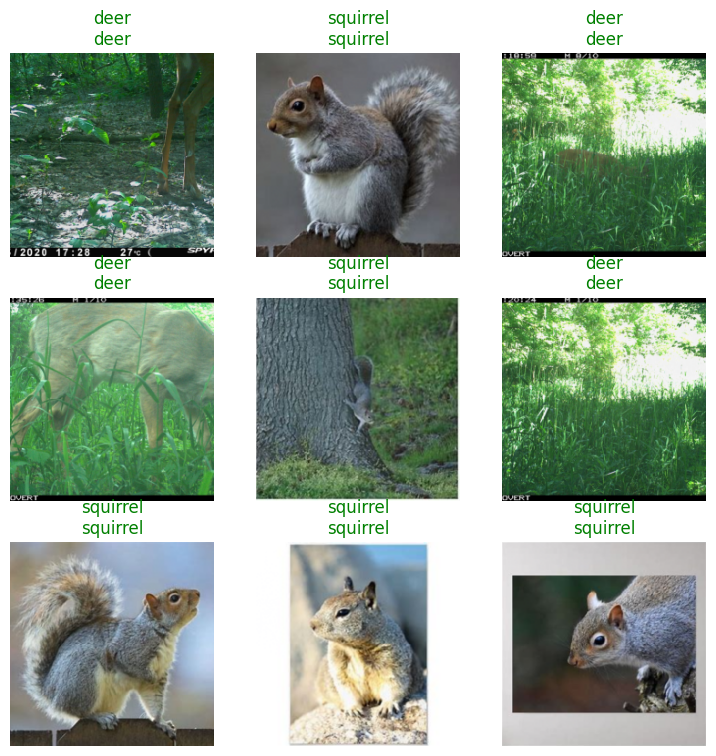

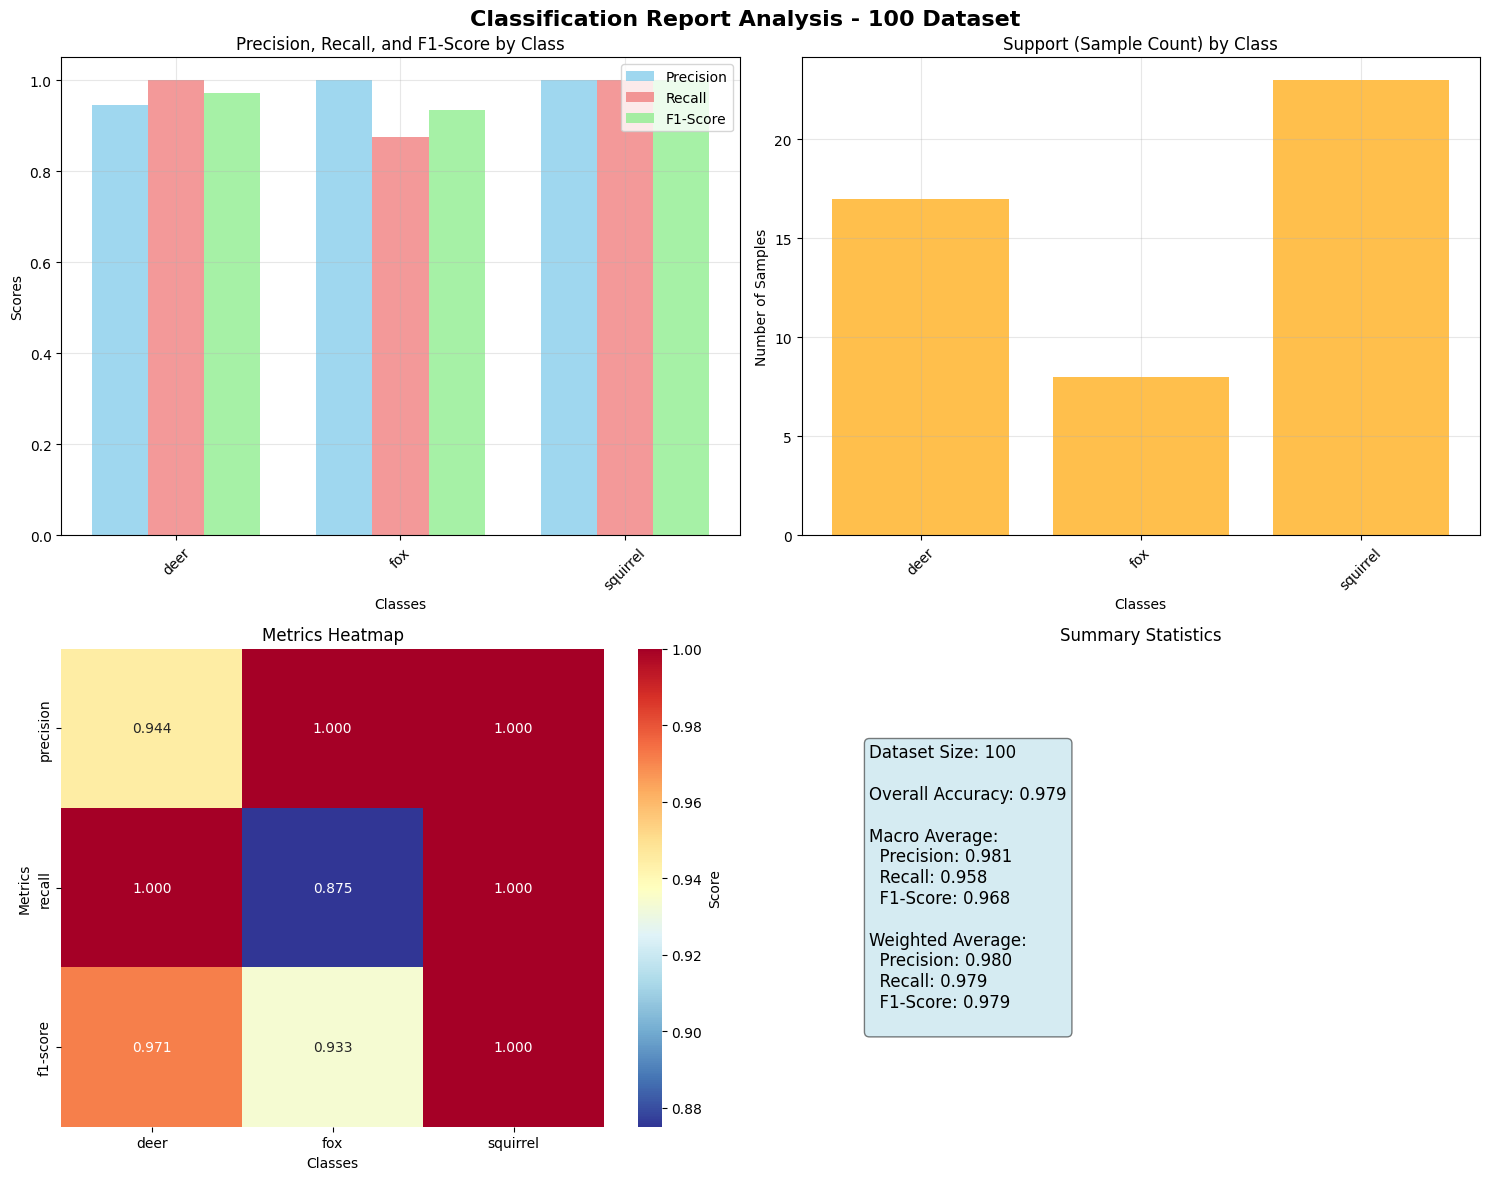


📋 Detailed Metrics Table:
          precision  recall  f1-score  support
deer          0.944   1.000     0.971     17.0
fox           1.000   0.875     0.933      8.0
squirrel      1.000   1.000     1.000     23.0

✅ Successfully processed 100 dataset
------------------------------------------------------------
✅ 100 Dataset processing completed successfully


In [ ]:
# Process 100 Dataset
if base_path:
    print("🚀 Starting 100 Dataset Analysis")
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 100

    results_100 = process_dataset_with_classification_report(base_path, species, dataset_size)

    if results_100:
        learn_100, df_100, report_100 = results_100
        print("✅ 100 Dataset processing completed successfully")
    else:
        print("❌ 100 Dataset processing failed")
else:
    print("❌ Cannot process dataset - base_path not available")

## 500 Datset Classification Report

🚀 Starting 500 Dataset Analysis

🔄 Processing 500 Dataset
📁 Collecting images for species: ['fox', 'squirrel', 'deer']
   🔍 Looking for fox images in: dataset-sizes/fox_500
   ✅ Found 500 fox images
   🔍 Looking for squirrel images in: dataset-sizes/squirrel_500
   ✅ Found 500 squirrel images
   🔍 Looking for deer images in: dataset-sizes/deer_500
   ✅ Found 500 deer images

📊 Total images collected: 1500
📈 Images per species:
   • fox: 500 images
   • squirrel: 500 images
   • deer: 500 images

🔧 Initializing data loaders...
✅ Data loaders initialized successfully

🖼️ Sample batch:

🧠 Initializing CNN learner with ResNet34...


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 71.2MB/s]


🏋️ Fine-tuning model for 4 epochs...



📋 Model results:



📊 Generating classification report...



📈 Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

        deer       1.00      0.99      1.00       119
         fox       1.00      1.00      1.00        99
    squirrel       0.99      1.00      0.99        82

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



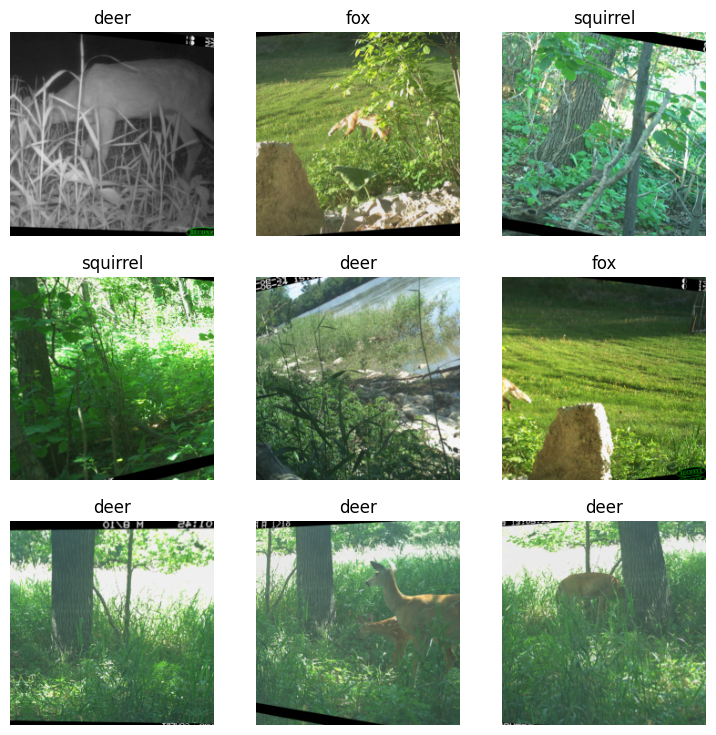

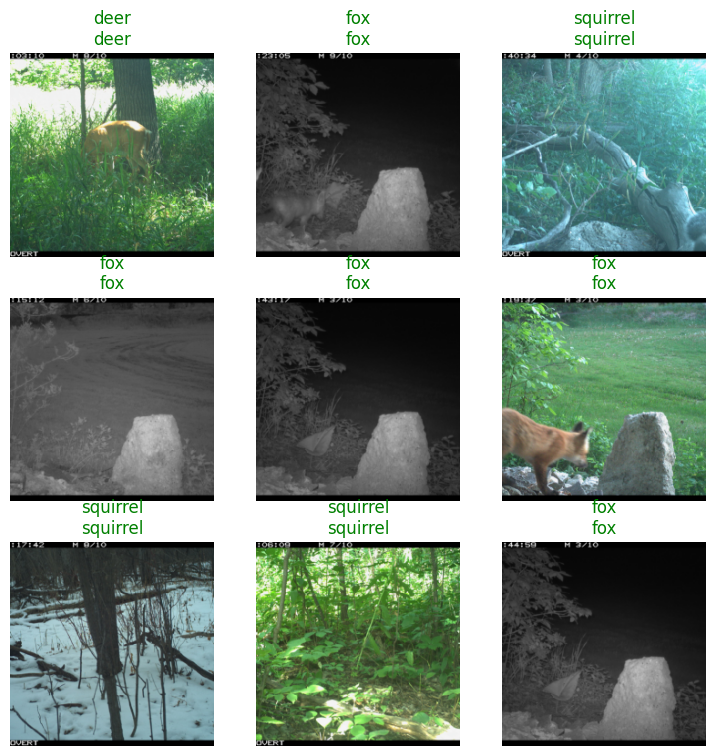

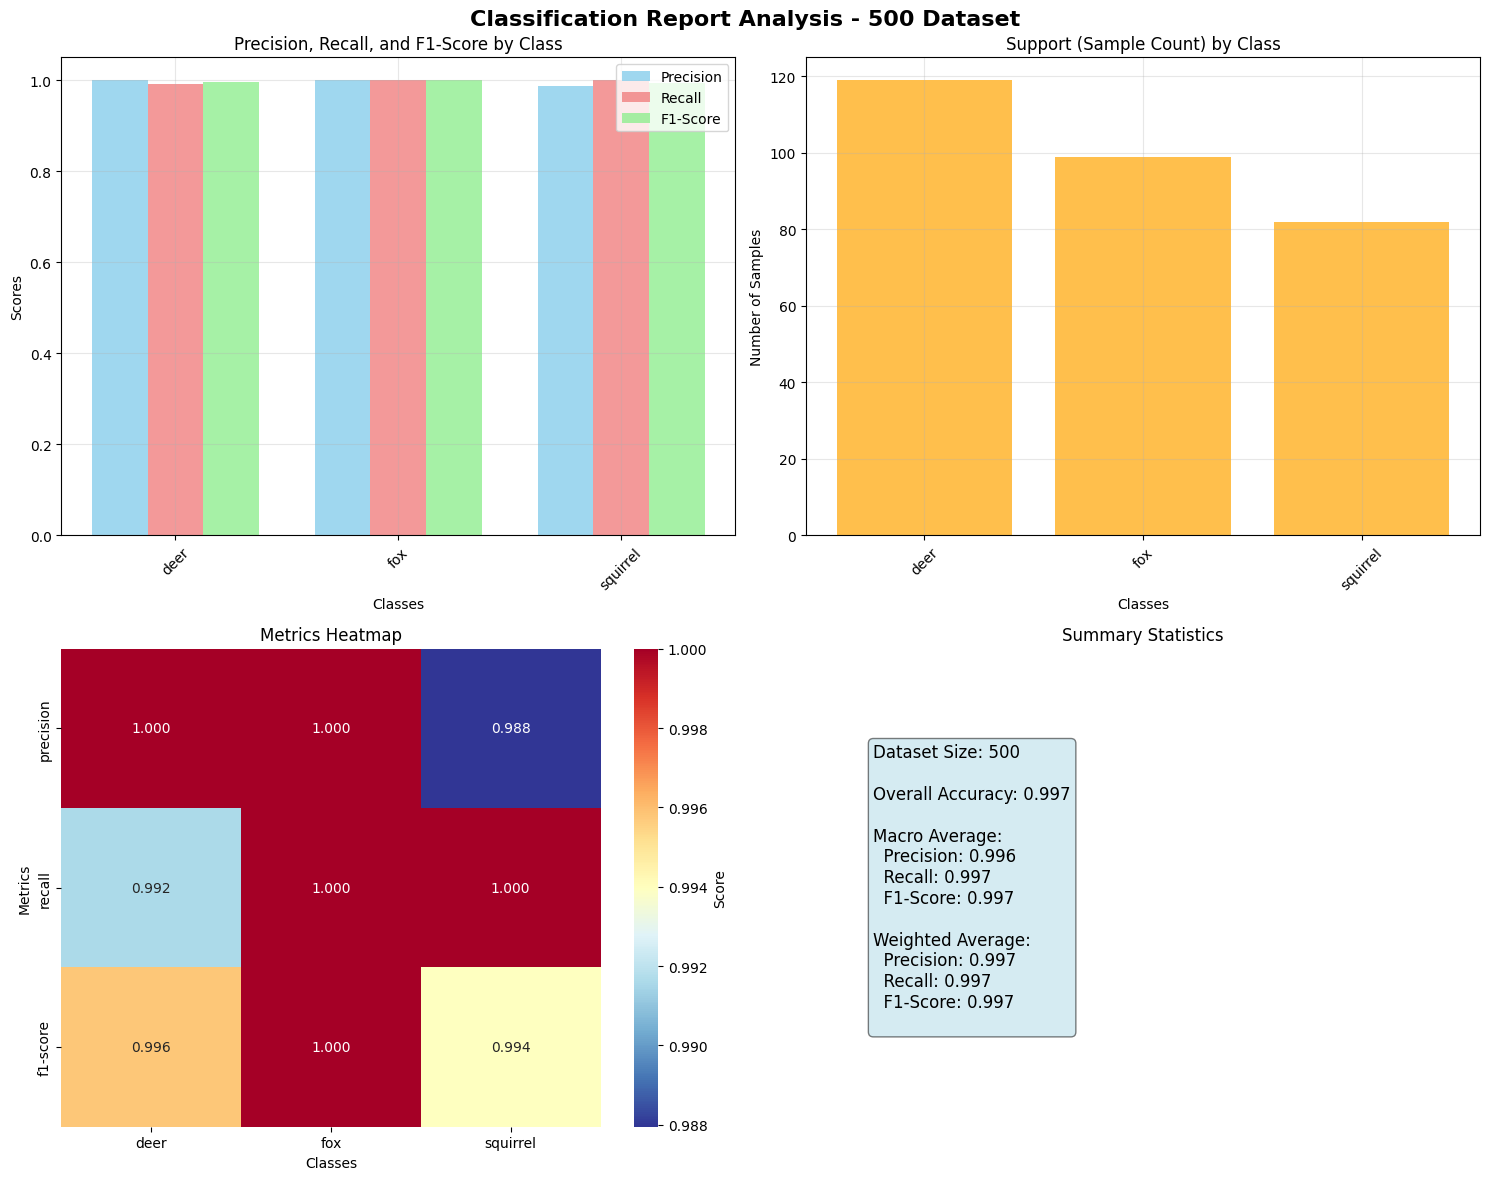


📋 Detailed Metrics Table:
          precision  recall  f1-score  support
deer          1.000   0.992     0.996    119.0
fox           1.000   1.000     1.000     99.0
squirrel      0.988   1.000     0.994     82.0

✅ Successfully processed 500 dataset
------------------------------------------------------------
✅ 500 Dataset processing completed successfully


In [ ]:
# Process 500 Dataset
if base_path:
    print("🚀 Starting 500 Dataset Analysis")
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 500

    results_500 = process_dataset_with_classification_report(base_path, species, dataset_size)

    if results_500:
        learn_500, df_500, report_500 = results_500
        print("✅ 500 Dataset processing completed successfully")
    else:
        print("❌ 500 Dataset processing failed")
else:
    print("❌ Cannot process dataset - base_path not available")

## 1000 Dataset Classification Report

In [ ]:
# Process 1000 Dataset
if base_path:
    print("🚀 Starting 1000 Dataset Analysis")
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 1000

    results_1000 = process_dataset_with_classification_report(base_path, species, dataset_size)

    if results_1000:
        learn_1000, df_1000, report_1000 = results_1000
        print("✅ 1000 Dataset processing completed successfully")
    else:
        print("❌ 1000 Dataset processing failed")
else:
    print("❌ Cannot process dataset - base_path not available")

🚀 Starting 1000 Dataset Analysis

🔄 Processing 1000 Dataset
📁 Collecting images for species: ['fox', 'squirrel', 'deer']
   🔍 Looking for fox images in: dataset-sizes/fox_1000
⚠️ Skipping file dataset-sizes/fox_1000/fox_847.JPG due to error: cannot identify image file 'dataset-sizes/fox_1000/fox_847.JPG'
⚠️ Skipping file dataset-sizes/fox_1000/fox_08.JPG due to error: cannot identify image file 'dataset-sizes/fox_1000/fox_08.JPG'
⚠️ Skipping file dataset-sizes/fox_1000/fox_726.JPG due to error: cannot identify image file 'dataset-sizes/fox_1000/fox_726.JPG'
⚠️ Skipping file dataset-sizes/fox_1000/fox_814.JPG due to error: cannot identify image file 'dataset-sizes/fox_1000/fox_814.JPG'
⚠️ Skipping file dataset-sizes/fox_1000/fox_638.JPG due to error: cannot identify image file 'dataset-sizes/fox_1000/fox_638.JPG'
⚠️ Skipping file dataset-sizes/fox_1000/fox_16.JPG due to error: cannot identify image file 'dataset-sizes/fox_1000/fox_16.JPG'
⚠️ Skipping file dataset-sizes/fox_1000/fox_187.

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


🏋️ Fine-tuning model for 4 epochs...


# Module: Comparative Analysis

This final module provides a comprehensive comparison of model performance across different dataset sizes, allowing for analysis of how training data quantity affects classification accuracy.

In [ ]:
# Comparative Analysis of All Datasets
def create_comparative_analysis():
    """
    Create a comparative analysis of all processed datasets
    """
    print("\n" + "="*70)
    print("📊 COMPARATIVE ANALYSIS ACROSS DATASET SIZES")
    print("="*70)

    # Check which datasets were successfully processed
    available_results = []

    if 'results_100' in locals() or 'results_100' in globals():
        try:
            if results_100 is not None:
                available_results.append((100, results_100))
        except NameError:
            pass

    if 'results_500' in locals() or 'results_500' in globals():
        try:
            if results_500 is not None:
                available_results.append((500, results_500))
        except NameError:
            pass

    if 'results_1000' in locals() or 'results_1000' in globals():
        try:
            if results_1000 is not None:
                available_results.append((1000, results_1000))
        except NameError:
            pass

    if not available_results:
        print("❌ No successfully processed datasets found for comparison")
        return

    print(f"📈 Comparing {len(available_results)} dataset sizes...")

    # Create comparison table
    comparison_data = []

    for size, (learner, df, report) in available_results:
        accuracy = df.loc['accuracy', 'precision'] if 'accuracy' in df.index else 0
        macro_avg = df.loc['macro avg'] if 'macro avg' in df.index else None
        weighted_avg = df.loc['weighted avg'] if 'weighted avg' in df.index else None

        comparison_data.append({
            'Dataset Size': size,
            'Accuracy': accuracy,
            'Macro Avg Precision': macro_avg['precision'] if macro_avg is not None else 0,
            'Macro Avg Recall': macro_avg['recall'] if macro_avg is not None else 0,
            'Macro Avg F1': macro_avg['f1-score'] if macro_avg is not None else 0,
            'Weighted Avg Precision': weighted_avg['precision'] if weighted_avg is not None else 0,
            'Weighted Avg Recall': weighted_avg['recall'] if weighted_avg is not None else 0,
            'Weighted Avg F1': weighted_avg['f1-score'] if weighted_avg is not None else 0
        })

    comparison_df = pd.DataFrame(comparison_data)

    # Display comparison table
    print("\n📋 Performance Comparison Table:")
    print(comparison_df.round(3).to_string(index=False))

    # Create visualization
    if len(available_results) > 1:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Performance Comparison Across Dataset Sizes', fontsize=16, fontweight='bold')

        # 1. Accuracy comparison
        axes[0, 0].bar(comparison_df['Dataset Size'], comparison_df['Accuracy'],
                      color='skyblue', alpha=0.8)
        axes[0, 0].set_title('Accuracy by Dataset Size')
        axes[0, 0].set_xlabel('Dataset Size')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Macro averages comparison
        x_pos = range(len(comparison_df))
        width = 0.25

        axes[0, 1].bar([p - width for p in x_pos], comparison_df['Macro Avg Precision'], width,
                      label='Precision', alpha=0.8)
        axes[0, 1].bar(x_pos, comparison_df['Macro Avg Recall'], width,
                      label='Recall', alpha=0.8)
        axes[0, 1].bar([p + width for p in x_pos], comparison_df['Macro Avg F1'], width,
                      label='F1-Score', alpha=0.8)

        axes[0, 1].set_title('Macro Average Metrics by Dataset Size')
        axes[0, 1].set_xlabel('Dataset Size')
        axes[0, 1].set_ylabel('Score')
        axes[0, 1].set_xticks(x_pos)
        axes[0, 1].set_xticklabels(comparison_df['Dataset Size'])
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Weighted averages comparison
        axes[1, 0].bar([p - width for p in x_pos], comparison_df['Weighted Avg Precision'], width,
                      label='Precision', alpha=0.8)
        axes[1, 0].bar(x_pos, comparison_df['Weighted Avg Recall'], width,
                      label='Recall', alpha=0.8)
        axes[1, 0].bar([p + width for p in x_pos], comparison_df['Weighted Avg F1'], width,
                      label='F1-Score', alpha=0.8)

        axes[1, 0].set_title('Weighted Average Metrics by Dataset Size')
        axes[1, 0].set_xlabel('Dataset Size')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].set_xticks(x_pos)
        axes[1, 0].set_xticklabels(comparison_df['Dataset Size'])
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # 4. Performance trends
        axes[1, 1].plot(comparison_df['Dataset Size'], comparison_df['Accuracy'],
                        marker='o', label='Accuracy', linewidth=2)
        axes[1, 1].plot(comparison_df['Dataset Size'], comparison_df['Macro Avg F1'],
                        marker='s', label='Macro Avg F1', linewidth=2)
        axes[1, 1].plot(comparison_df['Dataset Size'], comparison_df['Weighted Avg F1'],
                        marker='^', label='Weighted Avg F1', linewidth=2)

        axes[1, 1].set_title('Performance Trends')
        axes[1, 1].set_xlabel('Dataset Size')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # Performance insights
    print("\n🔍 Performance Insights:")
    if len(available_results) > 1:
        best_accuracy = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
        best_f1 = comparison_df.loc[comparison_df['Macro Avg F1'].idxmax()]

        print(f"   • Best accuracy: {best_accuracy['Accuracy']:.3f} (Dataset size: {best_accuracy['Dataset Size']})")
        print(f"   • Best macro F1-score: {best_f1['Macro Avg F1']:.3f} (Dataset size: {best_f1['Dataset Size']})")

        if len(available_results) >= 2:
            accuracy_improvement = comparison_df['Accuracy'].max() - comparison_df['Accuracy'].min()
            print(f"   • Accuracy improvement from smallest to largest dataset: {accuracy_improvement:.3f}")
    else:
        print("   • Only one dataset size processed - no comparison available")

    print("\n✅ Comparative analysis complete!")

# Run comparative analysis
create_comparative_analysis()